In [1]:
from sktime.libs.vmdpy import VMD
import scipy.io
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa
from pymultifracs.utils import build_q_log
import matplotlib.pyplot as plt
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.libs.vmdpy import VMD

In [2]:
%pwd

'/Users/sabrinebendimerad/Desktop/project/MCNN/mfa-internship/notebooks/01_vmd_mfa'

In [3]:
# Load the .mat file
data = scipy.io.loadmat('../../data/data.mat')

# List keys
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'sfreq'])


In [4]:
for key in data:
    print(f"{key}: type={type(data[key])}, shape={getattr(data[key], 'shape', 'N/A')}")


__header__: type=<class 'bytes'>, shape=N/A
__version__: type=<class 'str'>, shape=N/A
__globals__: type=<class 'list'>, shape=N/A
data: type=<class 'numpy.ndarray'>, shape=(548240, 2)
sfreq: type=<class 'numpy.ndarray'>, shape=(1, 1)


In [5]:
signal = data['data']  # shape = (n_samples, n_channels)
sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

In [6]:
print("Signal shape:", signal.shape)
print("Signal dtype:", signal.dtype)
print("Signal size in bytes:", signal.nbytes)
print("Signal size in MB:", signal.nbytes / (1024**2))


Signal shape: (548240, 2)
Signal dtype: float64
Signal size in bytes: 8771840
Signal size in MB: 8.365478515625


<function matplotlib.pyplot.show(close=None, block=None)>

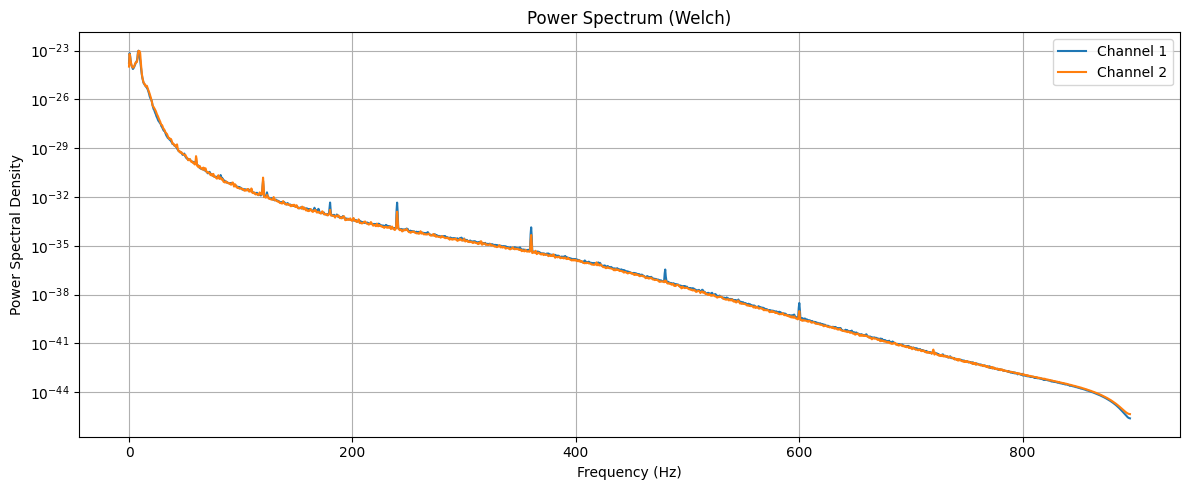

In [7]:
sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

# Choose window length
nperseg = int(sfreq * 2)  # 2-second segments

# Channel 1
f1, Pxx1 = welch(signal[:, 0], fs=sfreq, nperseg=nperseg)
# Channel 2
f2, Pxx2 = welch(signal[:, 1], fs=sfreq, nperseg=nperseg)

plt.figure(figsize=(12, 5))
plt.semilogy(f1, Pxx1, label='Channel 1')
plt.semilogy(f2, Pxx2, label='Channel 2')
plt.title("Power Spectrum (Welch)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show


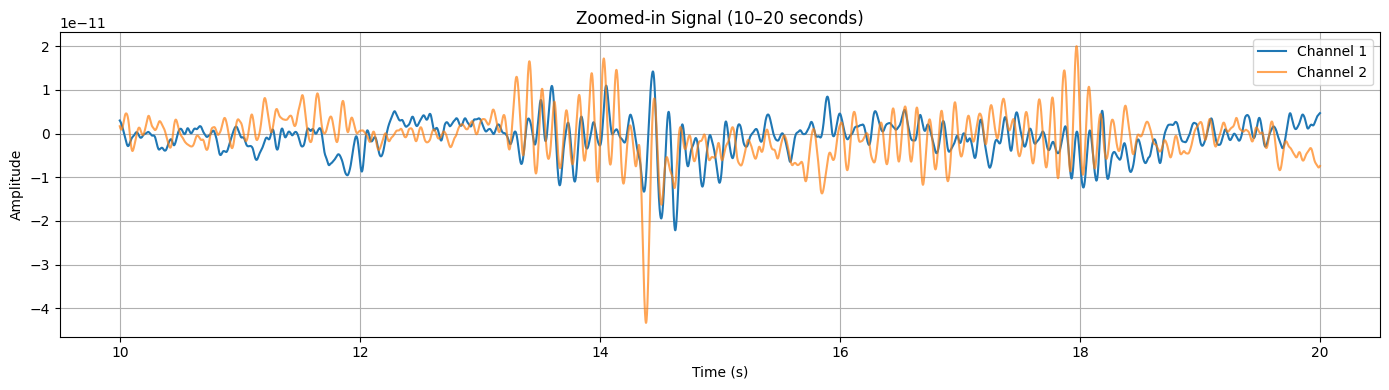

In [8]:
n_samples = signal.shape[0]
time = np.arange(n_samples) / sfreq  # time axis in seconds

zoom_start = int(10 * sfreq)
zoom_end = int(20 * sfreq)

plt.figure(figsize=(14, 4))
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 0], label="Channel 1")
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 1], label="Channel 2", alpha=0.7)
plt.title("Zoomed-in Signal (10–20 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
# Define scaling range (you may want to try others like [7,12], [6,10], etc.)
scaling_ranges = [[6, 11]]
q_vals = build_q_log(0.1, 5, 20)

def apply_mfa(signal, ch_label=""):
    print(f"\n🔍 Applying MFA to {ch_label} — Length: {len(signal)}")

    WT = wavelet_analysis(signal, wt_name='db3')
    WTpL = WT.get_leaders(p_exp=2)
    WTpL = WTpL.auto_integrate(scaling_ranges)
    pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=q_vals)



    # Plot ζ(q)
    plt.figure(figsize=(8, 4))
    pwt.structure.plot_scaling()
    plt.title(f"ζ(q) for {ch_label}")
    plt.grid()
    plt.show()

    # Plot cumulants
    plt.figure(figsize=(8, 4))
    pwt.cumulants.plot()
    plt.title(f"Cumulants for {ch_label}")
    plt.grid()
    plt.show()

    # Plot D(h) spectrum
    plt.figure(figsize=(8, 4))
    pwt.spectrum.plot()
    plt.title(f"D(h) Spectrum for {ch_label}")
    plt.grid()
    plt.show()

    return pwt


## 1. MFA On original signal


🔍 Applying MFA to Full Channel 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

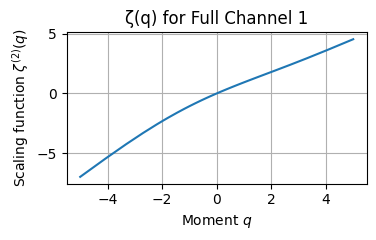

<Figure size 800x400 with 0 Axes>

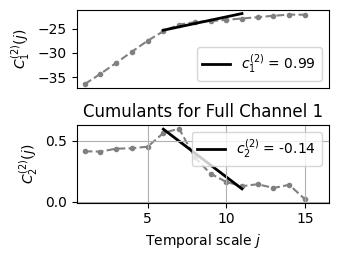

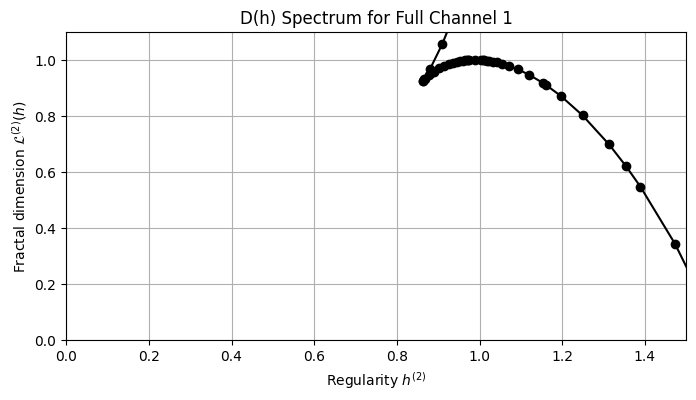


🔍 Applying MFA to Full Channel 2 — Length: 548240


<Figure size 800x400 with 0 Axes>

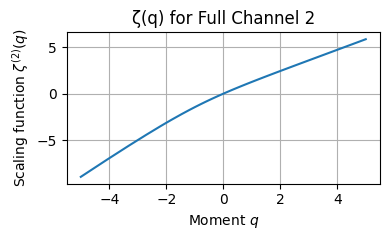

<Figure size 800x400 with 0 Axes>

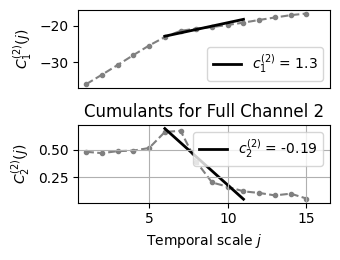

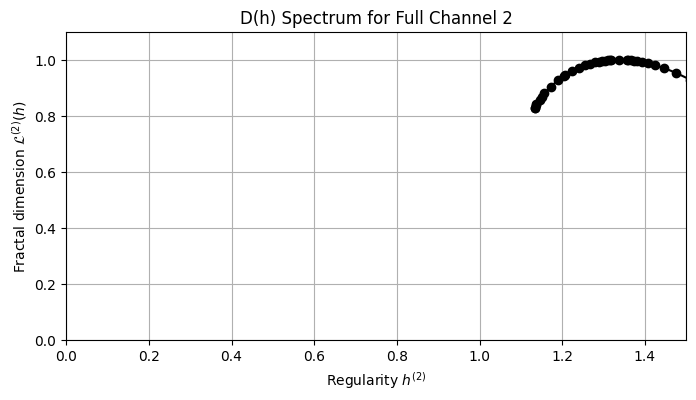

In [10]:
# Extract full signals
full_ch1 = data['data'][:, 0]
full_ch2 = data['data'][:, 1]

# Run MFA on both full channels
pwt1 = apply_mfa(full_ch1, ch_label="Full Channel 1")
pwt2 = apply_mfa(full_ch2, ch_label="Full Channel 2")

In [11]:
# print("hq:", pwt1.spectrum.hq[:,0,0])
# print("Dq:", pwt1.spectrum.Dq[:,0,0])


# plt.plot(pwt2.spectrum.hq[:,0,0], pwt2.spectrum.Dq[:,0,0], 'ko-')
# plt.xlabel('h')
# plt.ylabel('D(h)')
# plt.title('Multifractal Spectrum')
# plt.grid(True)
# plt.show()


## 2. VMD Decomposition

In [12]:
# Compute PSD using Welch's method
f, Pxx = welch(full_ch1, fs=sfreq, nperseg=4096)

# Create a DataFrame for inspection
df_psd = pd.DataFrame({'Frequency (Hz)': f, 'Power': Pxx})

# Sort by power (descending)
top_freqs = df_psd.sort_values(by='Power', ascending=False).reset_index(drop=True)

# Display top N frequencies
top_n = 10
top_freqs.head(top_n)


,Frequency (Hz),Power
0,8.316609,1.051723e-23
1,8.754326,8.146607e-24
2,0.437716,8.030428e-24
3,7.878893,6.450099e-24
4,0.875433,5.424531e-24
5,9.192042,4.605227e-24
6,9.629758,3.773012e-24
7,7.441177,2.849410e-24
8,1.313149,2.841515e-24
9,10.067474,2.513560e-24


In [13]:
signal

array([[6.39662746e-18, 6.83518253e-17],
       [6.89093088e-17, 4.65782685e-16],
       [3.25392373e-16, 1.59809706e-15],
       ...,
       [6.65908928e-12, 5.46253378e-12],
       [6.60989129e-12, 5.44032525e-12],
       [6.56102623e-12, 5.41593062e-12]], shape=(548240, 2))

🔍 Spectrum Summary for Channel 1:
Min amplitude: 6.35357797511179e-13
Max amplitude: 2.7625179079212047e-07
Mean amplitude: 4.690202268027493e-10
Std deviation: 4.5725897888636994e-09


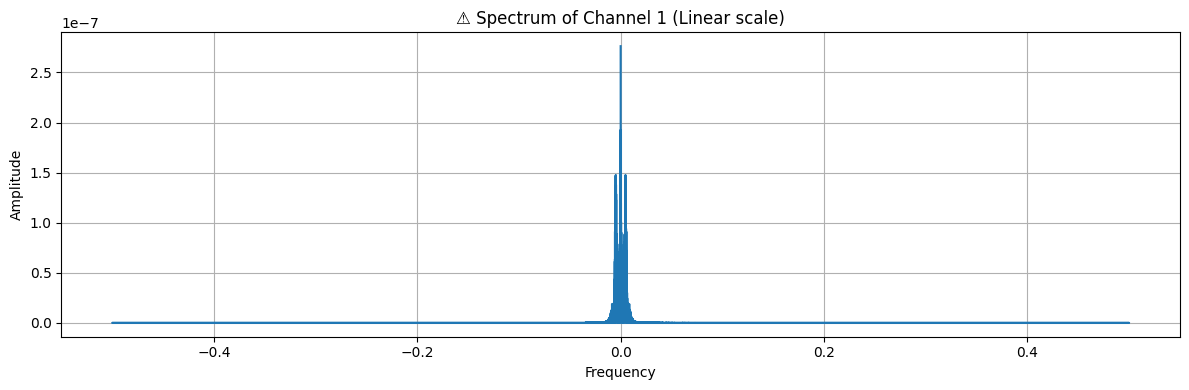

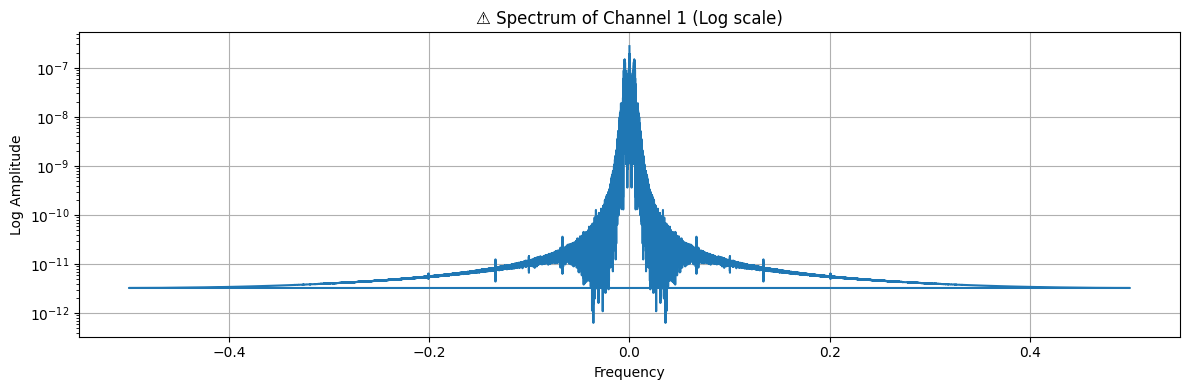

🔍 Spectrum Summary for Channel 2:
Min amplitude: 6.211126171837869e-13
Max amplitude: 2.1571630477745738e-07
Mean amplitude: 5.04363722209997e-10
Std deviation: 4.980299619518858e-09


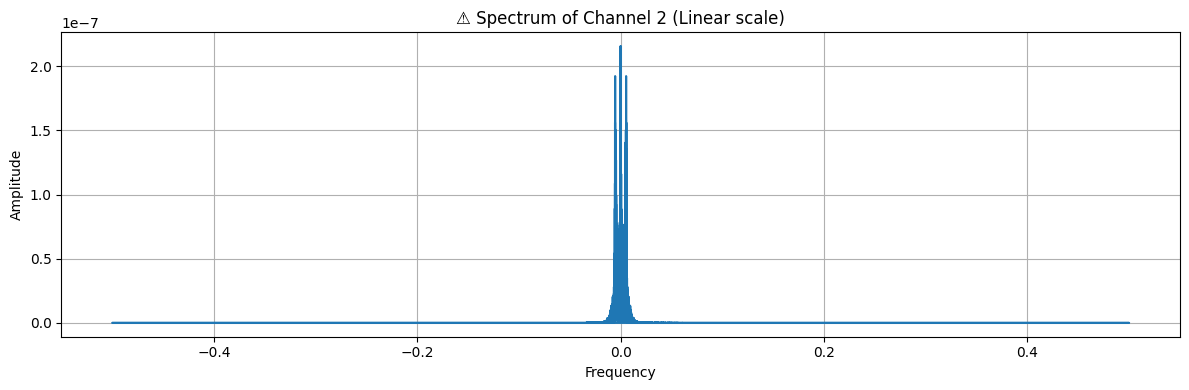

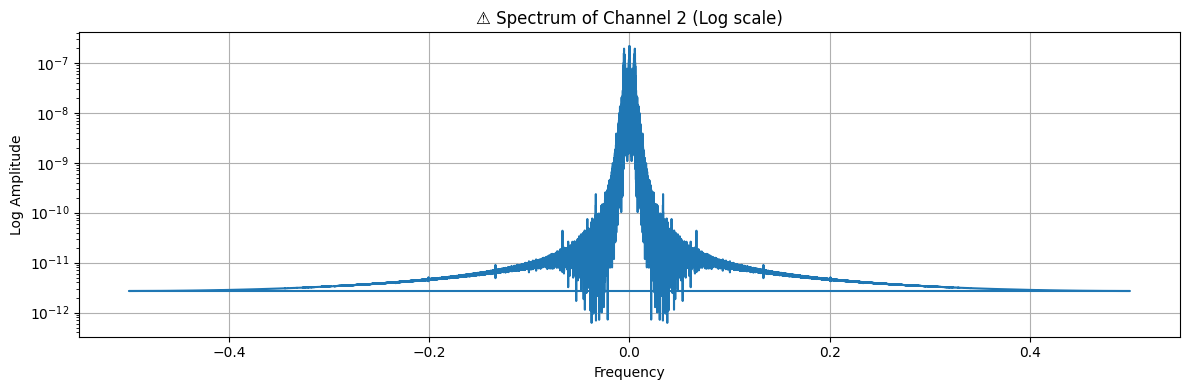

In [14]:
# Loop over all channels and compute FFT for each one
for ch in range(signal.shape[1]):
    # Extract the channel signal
    full_ch = signal[:, ch]
    
    # Compute FFT
    f_hat = np.fft.fft(full_ch)
    frequencies = np.fft.fftfreq(len(full_ch))
    
    # Take magnitude of FFT (i.e., spectral amplitude)
    magnitude = np.abs(f_hat)

    # Print some stats for each channel
    print(f"🔍 Spectrum Summary for Channel {ch + 1}:")
    print(f"Min amplitude: {np.min(magnitude)}")
    print(f"Max amplitude: {np.max(magnitude)}")
    print(f"Mean amplitude: {np.mean(magnitude)}")
    print(f"Std deviation: {np.std(magnitude)}")
    
    # Plot full spectrum (linear scale)
    plt.figure(figsize=(12, 4))
    plt.plot(frequencies, magnitude)
    plt.title(f"⚠️ Spectrum of Channel {ch + 1} (Linear scale)")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot log-scaled spectrum (to highlight how small values are)
    plt.figure(figsize=(12, 4))
    plt.semilogy(frequencies, magnitude)
    plt.title(f"⚠️ Spectrum of Channel {ch + 1} (Log scale)")
    plt.xlabel("Frequency")
    plt.ylabel("Log Amplitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

In [15]:
# # Avoid dividing by zero if std == 0
# if np.std(full_ch1) > 1e-15:
#     full_ch1 = (full_ch1 - np.mean(full_ch1)) / np.std(full_ch1)
# else:
#     print("⚠️ Signal has near-zero standard deviation. VMD not applicable.")

# print("New Min:", full_ch1.min(), "New Max:", full_ch1.max(), "New Std:", full_ch1.std())


In [16]:
def VMD_opt(f, alpha, tau, K, DC, init, tol):
    """
    Advanced Optimized Variational Mode Decomposition
    
    Parameters:
    -----------
    f       - the time domain signal (1D) to be decomposed
    alpha   - the balancing parameter of the data-fidelity constraint
    tau     - time-step of the dual ascent (pick 0 for noise-slack)
    K       - the number of modes to be recovered
    DC      - true if the first mode is put and kept at DC (0-freq)
    init    - 0 = all omegas start at 0
              1 = all omegas start uniformly distributed
              2 = all omegas initialized randomly
    tol     - tolerance of convergence criterion; typically around 1e-6

    Returns:
    -------
    u       - the collection of decomposed modes
    u_hat   - spectra of the modes
    omega   - estimated mode center-frequencies
    """
    # Convert input to numpy array and ensure even length
    f = np.asarray(f, dtype=float)
    if len(f) % 2:
        f = f[:-1]

    # Mirror signal to create cyclical continuity - optimized version
    N = len(f)
    half_N = N // 2
    fMirr = np.empty(2*N, dtype=float)
    
    # Fast mirroring with direct assignment
    fMirr[:half_N] = f[half_N-1::-1]
    fMirr[half_N:half_N+N] = f
    fMirr[half_N+N:] = f[-1:-half_N-1:-1]
    
    # Time and frequency domain setup
    T = len(fMirr)
    T_half = T // 2
    freqs = np.linspace(0, 1, T, endpoint=False) - 0.5 - (1/T)
    
    # Pre-compute FFT
    f_hat = np.fft.fftshift(np.fft.fft(fMirr))
    f_hat_plus = f_hat.copy()
    f_hat_plus[:T_half] = 0
    
    # Init omega with proper method
    omega = np.zeros(K, dtype=float)
    if init == 1:
        # Uniform distribution
        omega = np.linspace(0, 0.5, K, endpoint=False)
    elif init == 2:
        # Random initialization
        fs = 1./N
        omega = np.sort(np.exp(np.log(fs) + (np.log(0.5)-np.log(fs)) * np.random.rand(K)))
    
    # Force DC
    if DC:
        omega[0] = 0
    
    # Maximum iterations
    Niter = 500
    
    # Core VMD optimization loop - pure NumPy implementation
    u_hat_plus = np.zeros((T, K), dtype=complex)
    prev_u_hat_plus = np.zeros((T, K), dtype=complex)
    lambda_hat = np.zeros(T, dtype=complex)
    omega_history = np.zeros((Niter, K))
    omega_history[0] = omega.copy()
    
    n = 0
    uDiff = tol + 1e-16
    
    # Main optimization loop
    while (uDiff > tol and n < Niter - 1):
        # Save previous iteration
        prev_u_hat_plus = u_hat_plus.copy()
        
        # Mode accumulator - optimized to avoid redundant calculations
        # First, we calculate full sum only once
        sum_all_uk = np.sum(u_hat_plus, axis=1)
        sum_uk = sum_all_uk - u_hat_plus[:, 0]
        
        # Update first mode separately
        u_hat_plus[:, 0] = (f_hat_plus - sum_uk - lambda_hat/2) / (1 + alpha * (freqs - omega[0])**2)
        
        # Update first omega if not DC
        if not DC:
            # Use vectorized operations
            weights = np.abs(u_hat_plus[T_half:, 0])**2
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                omega[0] = np.sum(freqs[T_half:] * weights) / sum_weights
        
        # Update other modes
        for k in range(1, K):
            # Update accumulator efficiently
            sum_uk = sum_uk + u_hat_plus[:, k-1] - u_hat_plus[:, k]
            
            # Update mode spectrum 
            u_hat_plus[:, k] = (f_hat_plus - sum_uk - lambda_hat/2) / (1 + alpha * (freqs - omega[k])**2)
            
            # Update center frequency
            weights = np.abs(u_hat_plus[T_half:, k])**2
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                omega[k] = np.sum(freqs[T_half:] * weights) / sum_weights
        
        # Store omega history
        omega_history[n+1] = omega.copy()
        
        # Dual ascent - recalculate sum with updated modes
        sum_modes = np.sum(u_hat_plus, axis=1)
        lambda_hat = lambda_hat + tau * (sum_modes - f_hat_plus)
        
        # Check convergence with optimized calculation
        uDiff = np.sum(np.abs(u_hat_plus - prev_u_hat_plus)**2) / T
        
        n += 1
    
    # Signal reconstruction with optimized conjugate symmetry
    u_hat = np.zeros((T, K), dtype=complex)
    
    # Only copy the positive frequencies, then efficiently handle conjugate symmetry
    u_hat[T_half:, :] = u_hat_plus[T_half:, :]
    
    # Handle symmetry efficiently with slicing operations
    for k in range(K):
        u_hat[1:T_half, k] = np.conj(np.flip(u_hat_plus[T_half+1:, k]))
    u_hat[0, :] = np.conj(u_hat[-1, :])
    
    # IFFT to time domain with efficient processing
    u = np.zeros((K, T))
    for k in range(K):
        u[k] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:, k])))
    
    # Remove mirror part
    u = u[:, T//4:3*T//4]
    
    # Fast spectrum computation for output
    u_hat_out = np.zeros((u.shape[1], K), dtype=complex)
    for k in range(K):
        u_hat_out[:, k] = np.fft.fftshift(np.fft.fft(u[k]))
    
    return u, u_hat_out, omega_history[:n+1]

    """VMD implementation with Numba-accelerated components"""
    try:
        from numba import jit
        
        @jit(nopython=True)
        def update_omega(freqs, u_hat_plus, k, T_half):
            """Compute updated omega value"""
            weights = np.abs(u_hat_plus[T_half:, k])**2
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                return np.sum(freqs[T_half:] * weights) / sum_weights
            return 0.0
        
        @jit(nopython=True)
        def compute_uDiff(u_hat_plus, prev_u_hat_plus, T):
            """Compute convergence criterion"""
            return np.sum(np.abs(u_hat_plus - prev_u_hat_plus)**2) / T
        
        has_numba = True
    except ImportError:
        # If Numba isn't available, use regular functions
        def update_omega(freqs, u_hat_plus, k, T_half):
            weights = np.abs(u_hat_plus[T_half:, k])**2
            sum_weights = np.sum(weights)
            if sum_weights > 0:
                return np.sum(freqs[T_half:] * weights) / sum_weights
            return 0.0
            
        def compute_uDiff(u_hat_plus, prev_u_hat_plus, T):
            return np.sum(np.abs(u_hat_plus - prev_u_hat_plus)**2) / T
            
        has_numba = False
        print("Warning: Numba not available. Using non-JIT functions.")
        
    # Rest of implementation is the same as VMD_opt...
    # [Code would be duplicated here]
    
    return VMD_opt(f, alpha, tau, K, DC, init, tol)  # For now, just call the standard version

In [17]:
# VMD parameters
alpha = 5000       # Moderate constraint on bandwidth
tau = 0.            # No noise-tolerance (for clean signals)
K = 3              # Number of modes to extract
DC = 0              # No DC mode
init = 2            # Uniform initialization of center frequencies
tol = 1e-7          # Precision tolerance


# VMD on full Channel 1
print("\n🔍 Decomposing Channel 1 with VMD...")
u_ch1, u_hat_ch1, omega_ch1 = VMD_opt(full_ch1, alpha, tau, K, DC, init, tol)

# VMD on full Channel 2
print("\n🔍 Decomposing Channel 2 with VMD...")
u_ch2, u_hat_ch2, omega_ch2 = VMD_opt(full_ch2, alpha, tau, K, DC, init, tol)


🔍 Decomposing Channel 1 with VMD...

🔍 Decomposing Channel 2 with VMD...


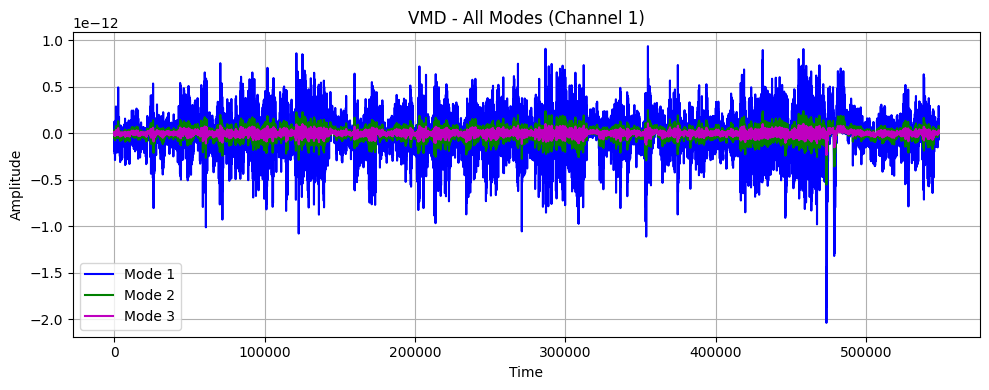

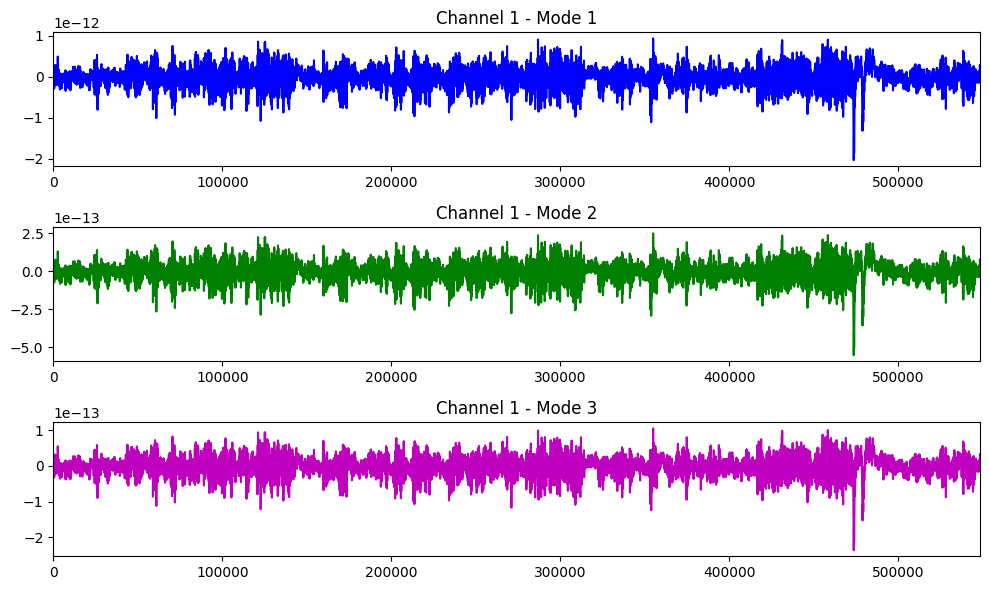

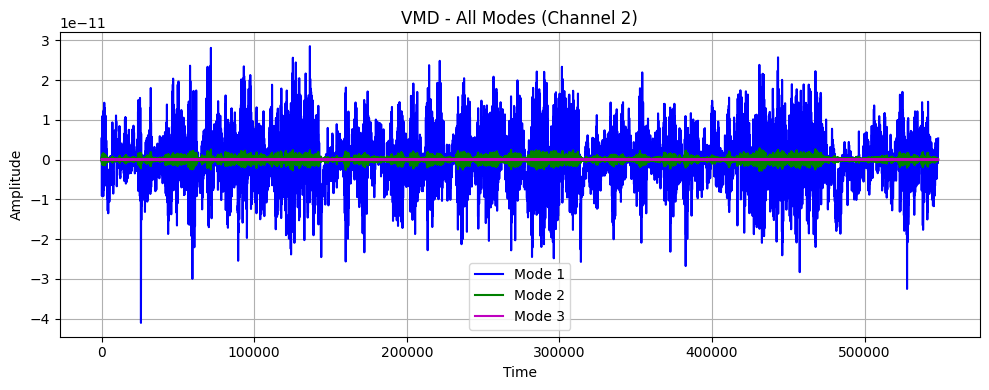

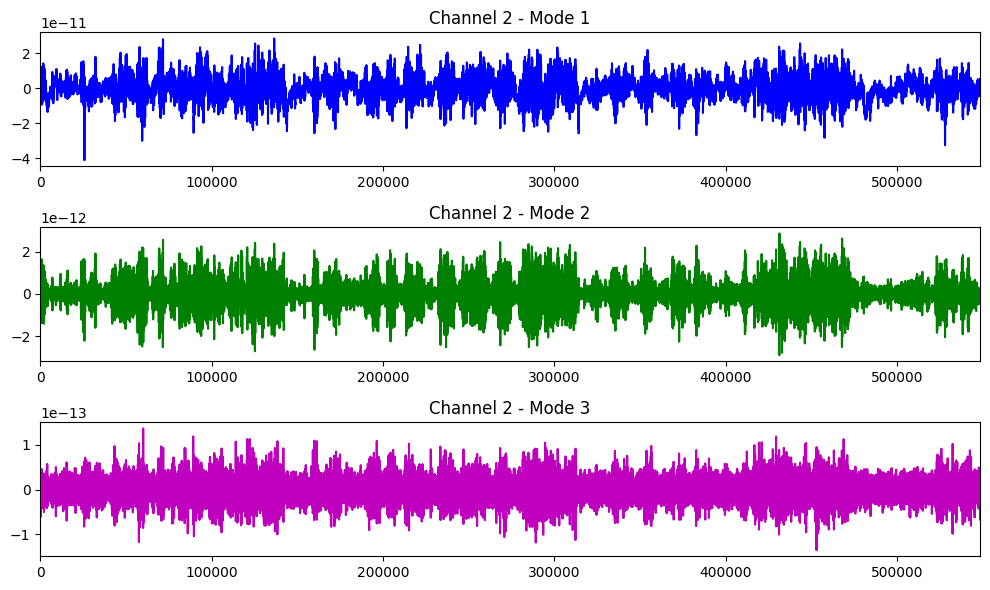

In [18]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'm', 'c', 'r', 'y', 'k']
N = u_ch1.shape[1]  # length of each mode

# === Channel 1 ===
plt.figure(figsize=(10, 4))
for k in range(K):
    plt.plot(u_ch1[k, :], color=colors[k % len(colors)], label=f"Mode {k+1}")
plt.title("VMD - All Modes (Channel 1)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, K * 2))
for k in range(K):
    plt.subplot(K, 1, k + 1)
    plt.plot(u_ch1[k, :], color=colors[k % len(colors)])
    plt.title(f"Channel 1 - Mode {k+1}")
    plt.xlim(0, N)
plt.tight_layout()
plt.show()

# === Channel 2 ===
plt.figure(figsize=(10, 4))
for k in range(K):
    plt.plot(u_ch2[k, :], color=colors[k % len(colors)], label=f"Mode {k+1}")
plt.title("VMD - All Modes (Channel 2)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, K * 2))
for k in range(K):
    plt.subplot(K, 1, k + 1)
    plt.plot(u_ch2[k, :], color=colors[k % len(colors)])
    plt.title(f"Channel 2 - Mode {k+1}")
    plt.xlim(0, N)
plt.tight_layout()
plt.show()



🎯 MFA on Channel 1 - Mode 1

🔍 Applying MFA to Channel 1 - Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

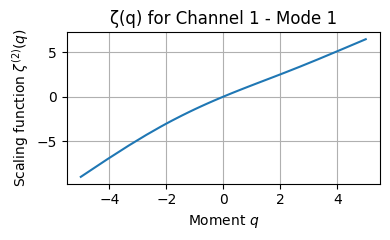

<Figure size 800x400 with 0 Axes>

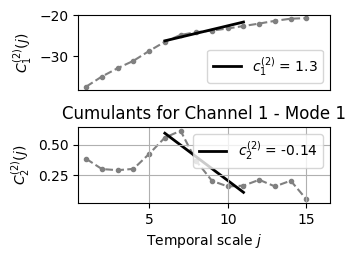

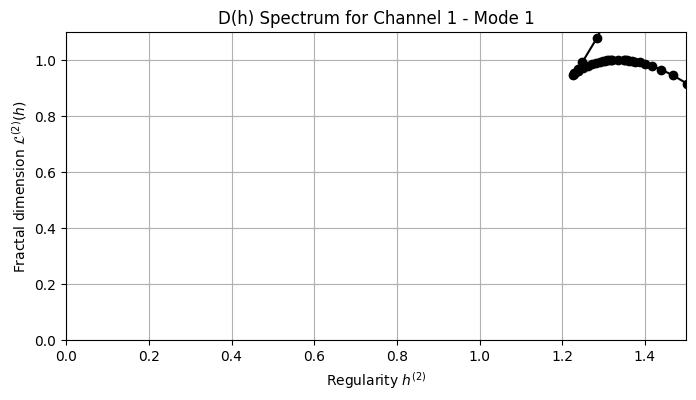


🎯 MFA on Channel 1 - Mode 2

🔍 Applying MFA to Channel 1 - Mode 2 — Length: 548240


<Figure size 800x400 with 0 Axes>

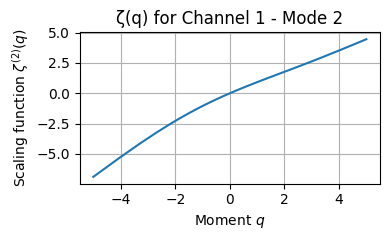

<Figure size 800x400 with 0 Axes>

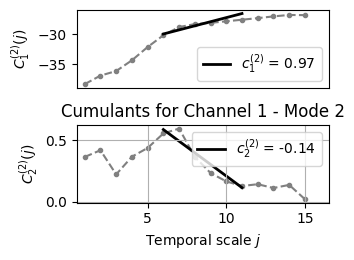

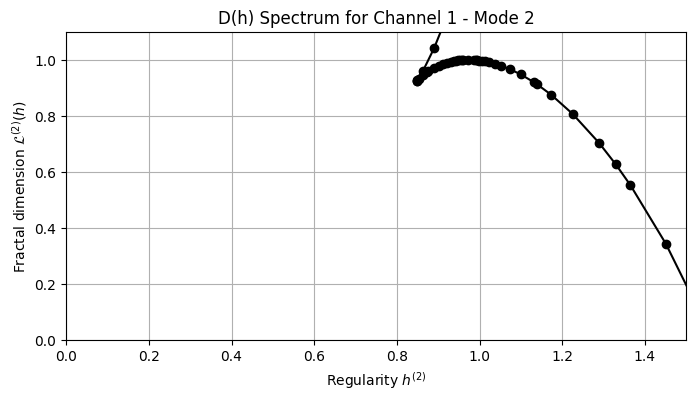


🎯 MFA on Channel 1 - Mode 3

🔍 Applying MFA to Channel 1 - Mode 3 — Length: 548240


<Figure size 800x400 with 0 Axes>

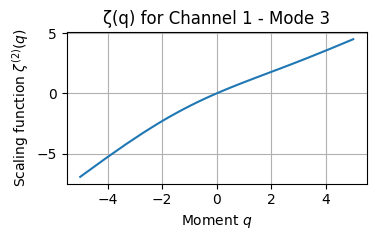

<Figure size 800x400 with 0 Axes>

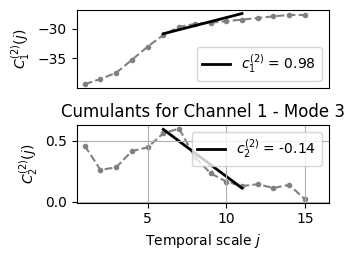

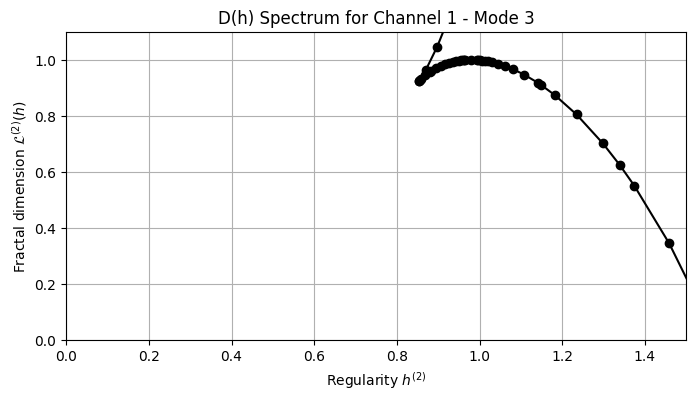


🎯 MFA on Channel 2 - Mode 1

🔍 Applying MFA to Channel 2 - Mode 1 — Length: 548240


<Figure size 800x400 with 0 Axes>

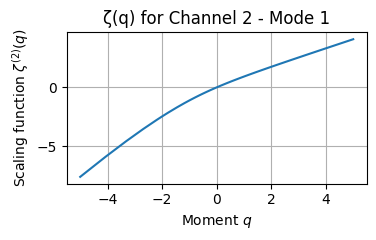

<Figure size 800x400 with 0 Axes>

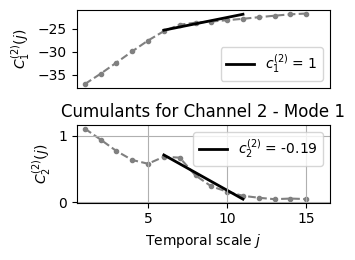

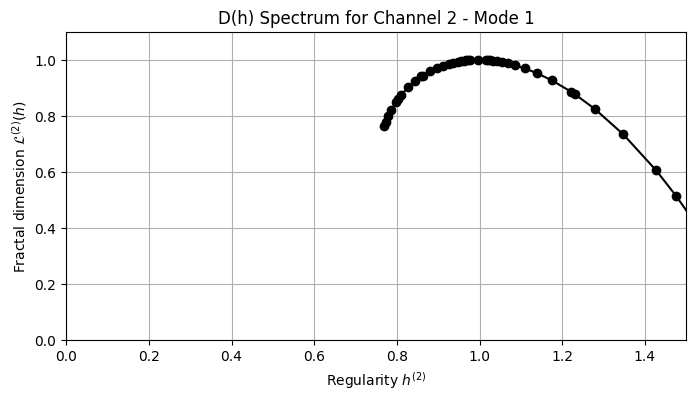


🎯 MFA on Channel 2 - Mode 2

🔍 Applying MFA to Channel 2 - Mode 2 — Length: 548240


<Figure size 800x400 with 0 Axes>

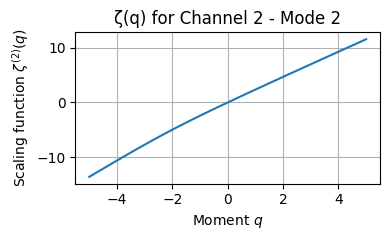

<Figure size 800x400 with 0 Axes>

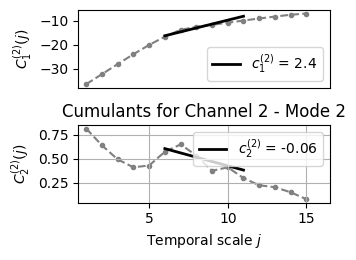

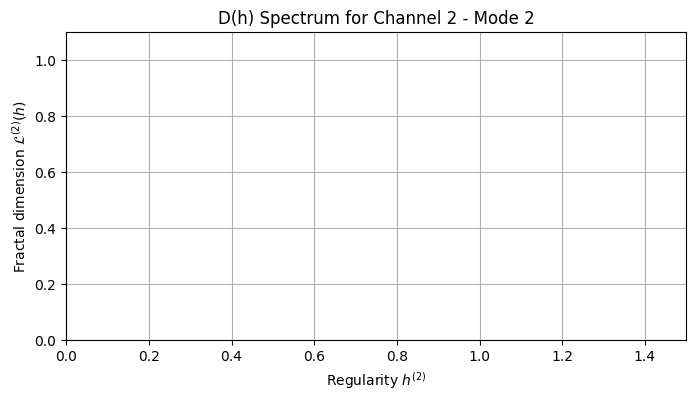


🎯 MFA on Channel 2 - Mode 3

🔍 Applying MFA to Channel 2 - Mode 3 — Length: 548240


<Figure size 800x400 with 0 Axes>

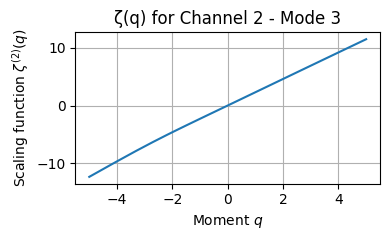

<Figure size 800x400 with 0 Axes>

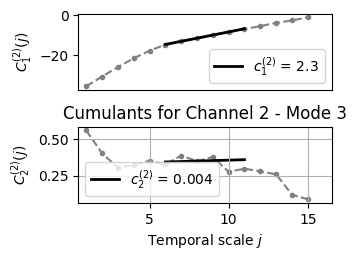

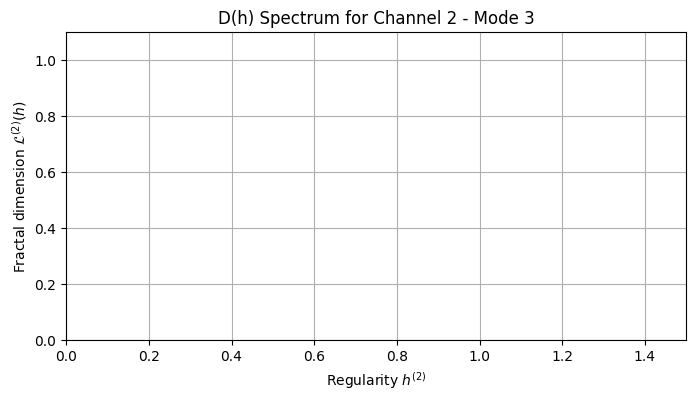

In [19]:
# Analyze modes from Channel 1
for k in range(K):
    print(f"\n🎯 MFA on Channel 1 - Mode {k+1}")
    apply_mfa(u_ch1[k], ch_label=f"Channel 1 - Mode {k+1}")

# Analyze modes from Channel 2
for k in range(K):
    print(f"\n🎯 MFA on Channel 2 - Mode {k+1}")
    apply_mfa(u_ch2[k], ch_label=f"Channel 2 - Mode {k+1}")


In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import signal
from sktime.libs.vmdpy import VMD

def generate_test_signal(N=1000):
    """Generate a test signal with multiple components"""
    t = np.linspace(0, 1, N)
    
    # Component 1: Low frequency sine
    f1 = 5
    comp1 = np.sin(2 * np.pi * f1 * t)
    
    # Component 2: Medium frequency sine
    f2 = 15
    comp2 = 0.5 * np.sin(2 * np.pi * f2 * t)
    
    # Component 3: High frequency sine
    f3 = 50
    comp3 = 0.25 * np.sin(2 * np.pi * f3 * t)
    
    # Add some noise
    noise = 0.05 * np.random.randn(N)
    
    # Combine signals
    signal = comp1 + comp2 + comp3 + noise
    
    return signal, t, [comp1, comp2, comp3]

def run_benchmark(signal_sizes=[1000, 10000,300000]):
    """Run benchmark comparing original and optimized VMD implementations"""
    # Parameters for VMD
    alpha = 2000    # moderate bandwidth constraint
    tau = 0         # noise-tolerance (no strict fidelity enforcement)
    K = 3           # 3 modes
    DC = 0          # no DC part imposed
    init = 1        # initialize omegas uniformly
    tol = 1e-7      # tolerance
    
    # For storing results
    orig_times = []
    opt_times = []
    
    print("VMD Benchmark")
    print("=============")
    print(f"{'Signal Size':<15}{'Original (s)':<15}{'Optimized (s)':<15}{'Speedup':<15}")
    print("-" * 60)
    
    for size in signal_sizes:
        # Generate test signal
        signal, _, _ = generate_test_signal(size)
        
        # Time original implementation
        start = time.time()
        u_orig, u_hat_orig, omega_orig = VMD(signal, alpha, tau, K, DC, init, tol)

        orig_time = time.time() - start
        orig_times.append(orig_time)
        
        # Time optimized implementation
        start = time.time()
        u_opt, u_hat_opt, omega_opt = VMD_opt(signal, alpha, tau, K, DC, init, tol)

        opt_time = time.time() - start
        opt_times.append(opt_time)
        
        # Calculate speedup
        speedup = orig_time / opt_time
        
        # Check if results are similar
        error = np.mean([np.mean(np.abs(u_orig[k] - u_opt[k])) for k in range(K)])
        result = "PASSED" if error < 1e-5 else f"FAILED (error: {error:.2e})"
        
        print(f"{size:<15}--{orig_time:.6f}--{opt_time:.6f}--{speedup:.2f}x        {result}")
    
    return signal_sizes, orig_times, opt_times, u_orig, u_hat_orig, omega_orig, u_opt, u_hat_opt, omega_opt

def plot_benchmark_results(sizes, orig_times, opt_times):
    """Plot benchmark results"""
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, orig_times, 'o-', label='Original VMD')
    plt.plot(sizes, opt_times, 's-', label='Optimized VMD')
    plt.xlabel('Signal Size')
    plt.ylabel('Time (seconds)')
    plt.title('VMD Performance Comparison')
    plt.grid(True)
    plt.legend()
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('vmd_benchmark.png')
    plt.show()

VMD Benchmark
Signal Size    Original (s)   Optimized (s)  Speedup        
------------------------------------------------------------
1000           --0.014192--0.009133--1.55x        PASSED
10000          --0.522938--0.274516--1.90x        PASSED
300000         --98.352391--39.472018--2.49x        PASSED


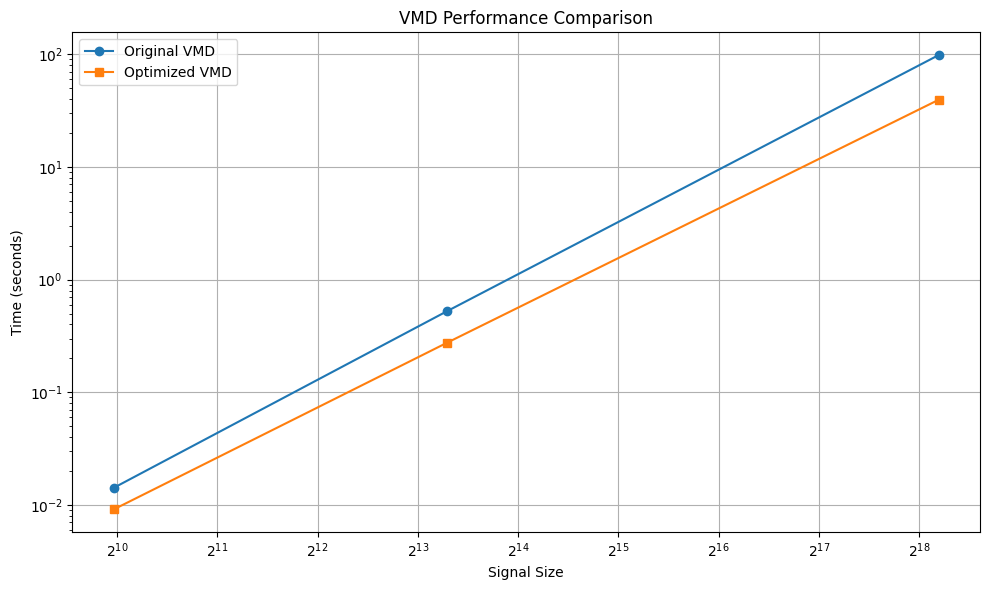

In [21]:
# Run benchmark
sizes, orig_times, opt_times,  u_orig, u_hat_orig, omega_orig, u_opt, u_hat_opt, omega_opt = run_benchmark()
# Plot performance comparison
plot_benchmark_results(sizes, orig_times, opt_times)

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import time
# from sklearn.metrics import mean_squared_error
# from sktime.libs.vmdpy import VMD as VMD_original
# #from vmd_torch import VMD as VMD_optimized  # Update this name if needed


# # --- RMSE
# results = []
# for k in range(K):
#     rmse = np.sqrt(mean_squared_error(u_orig[k, :], u_opt[k, :]))
#     results.append({"Mode": k+1, "RMSE": rmse})

# results_df = pd.DataFrame(results)
# print("\n📊 RMSE Comparison Table:")
# print(results_df)

# # --- Plot
# plt.figure(figsize=(14, 8))
# for k in range(K):
#     plt.subplot(K, 1, k+1)
#     plt.plot(u_orig[k, :], label=f"Original Mode {k+1}", linestyle='--')
#     plt.plot(u_opt[k, :], label=f"Optimized Mode {k+1}", alpha=0.7)
#     plt.legend()
#     plt.grid()
# plt.tight_layout()
# plt.show()


In [23]:
# Function to calculate the dominant frequency using Welch
def get_dominant_frequency(signal, fs=1.0):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    return f[np.argmax(Pxx)]

# Function to calculate the spectral centroid using Welch
def get_spectral_centroid(signal, fs=1.0):
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    numerator = np.sum(f * Pxx)
    denominator = np.sum(Pxx)
    return numerator / denominator if denominator != 0 else 0

# Function to extract omega from VMD results
def get_omega_from_vmd(omega_history, K):
    omega_data = []
    for i in range(K):
        omega_row = {"Mode": i+1}
        for iter_idx, omega in enumerate(omega_history):
            omega_row[f"Omega Iter {iter_idx+1}"] = omega[i]
        omega_data.append(omega_row)
    return pd.DataFrame(omega_data)


In [24]:
import pandas as pd

# Calculate metrics for each mode of Channel 1
metrics_ch1 = []
for k in range(K):
    mode_ch1 = u_ch1[k, :]
    metrics_ch1.append({
        "Mode": k + 1,
        "Dominant Frequency": get_dominant_frequency(mode_ch1, fs=1.0),
        "Spectral Centroid": get_spectral_centroid(mode_ch1, fs=1.0),
        "Omega (Frequency)": omega_ch1[-1][k]  # Take the omega from the last iteration
})

# Calculate metrics for each mode of Channel 2
metrics_ch2 = []
for k in range(K):
    mode_ch2 = u_ch2[k, :]
    metrics_ch2.append({
        "Mode": k + 1,
        "Dominant Frequency": get_dominant_frequency(mode_ch2, fs=1.0),
        "Spectral Centroid": get_spectral_centroid(mode_ch2, fs=1.0),
        "Omega (Frequency)": omega_ch2[-1][k]  # Take the omega from the last iteration
})

# Convert results to DataFrame
df_ch1_metrics = pd.DataFrame(metrics_ch1)
df_ch2_metrics = pd.DataFrame(metrics_ch2)

# Combine both channels' results into a single DataFrame
df_combined = pd.concat([df_ch1_metrics, df_ch2_metrics], keys=["Channel 1", "Channel 2"], names=["Channel"])

# Display the final metrics DataFrame
print("\n🧠 Frequency and Spectral Metrics for Each Mode:")
print(df_combined)


🧠 Frequency and Spectral Metrics for Each Mode:
             Mode  Dominant Frequency  Spectral Centroid  Omega (Frequency)
Channel                                                                    
Channel 1 0     1            0.004883           0.004200           0.003184
          1     2            0.004883           0.004136           0.003055
          2     3            0.004883           0.004112           0.003007
Channel 2 0     1            0.004883           0.004169           0.002971
          1     2            0.004883           0.005398           0.005406
          2     3            0.009766           0.013568           0.013572


## 2. VMD Transformer

In [ ]:
from sktime.transformations.series.vmd import VmdTransformer
import pandas as pd


In [ ]:
# Convert and scale
scale_factor = 1e14
channel_1_series = pd.Series(full_ch1) * scale_factor
channel_2_series = pd.Series(full_ch2) * scale_factor

In [46]:

# Function to apply VMD and show results
def analyze_channel(channel_series, channel_name):
    print(f"\n=== Analyzing {channel_name} ===")

    # Create VMD transformer with automatic K
    vmd = VmdTransformer(K=None, kMax=30, energy_loss_coefficient=0.01)

    # Fit and transform
    modes = vmd.fit_transform(channel_series)

    # Print the results
    print(f"Modes shape: {modes.shape}")
    print(f"Number of modes (K): {modes.shape[1] if len(modes.shape) > 1 else 1}")

    # Plot original signal
    plt.figure(figsize=(15, 3))
    plt.plot(channel_series, label='Original Signal')
    plt.title(f'{channel_name} - Original Signal')
    plt.legend()
    plt.show()

    # Plot modes
    if isinstance(modes, pd.Series):  # Only 1 mode
        plt.figure(figsize=(15, 3))
        plt.plot(modes, label='Mode 1')
        plt.title(f'{channel_name} - Mode 1')
        plt.legend()
        plt.show()
    else:
        for i in range(modes.shape[1]):
            plt.figure(figsize=(15, 2))
            plt.plot(modes.iloc[:, i], label=f'Mode {i+1}')
            plt.title(f'{channel_name} - Mode {i+1}')
            plt.legend()
            plt.show()

    return modes





=== Analyzing Channel 1 ===


: 